In [93]:
import os
import audiolabel
import ultratils.pysonix.bprreader

import pandas as pd
import numpy as np
import parselmouth
import random

import scipy.signal as sg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import audosync
import derivatives as der

In [94]:
datadir = os.path.abspath('/media/sf_raw_qp_data/')

In [124]:
testsubj = '121'
testcase = '2015-10-30T104025-0700'

# read in the BPR
bprloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr')
bpr = ultratils.pysonix.bprreader.BprReader(bprloc)

# read in the audio
auloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.wav')
au = parselmouth.Sound(auloc)
au = au.extract_channel(1)

In [125]:
# read in the known synchronization data, and create a dataframe to add to
syncloc = os.path.join(datadir, testsubj, testcase, testcase+'.bpr.sync.txt')

# the first tier in this object is the number of the pulse, the second is the actual frame number
frame_times = audiolabel.LabelManager(from_file = syncloc, from_type='table', t1_col='seconds').as_df()[1]
frame_times = frame_times.rename(columns={'text':'frameN','t1':'time'})
frame_times.head()

,time,frameN
0,0.1734,0
1,0.1822,1
2,0.1910,2
3,0.1999,3
4,0.2087,4


In [126]:
frames = [bpr.get_frame(i) for i in range(0, bpr.nframes)]
frames=np.array(frames)
print(frames.shape[:])

(192, 416, 69)


In [127]:
frame_array = der.diffs(frames,2)
diff_quant_acc = der.derval(frame_array)

In [128]:
frame_times['diff_quant_acc'] = frame_times['frameN'].apply(lambda x: diff_quant_acc[int(x)-1] if (x!='NA' and int(x)>0) else np.nan)

In [129]:
pmfcc = au.to_mfcc()
mfcc = np.transpose(pmfcc.to_array())  # transpose this to get time (frames) on the first dimension

One way to calculate diff of diffs is to create an array of diffs (raw) and then calculate the next set of diffs on that array. I think that's the correct way to do it.

In [130]:
au_diff1 = [mfcc[i]-mfcc[i-1] for i in range(1, len(mfcc))]
au_diff2 = [np.mean(np.abs(au_diff1[i]-au_diff1[i-1])) for i in range(1, len(au_diff1))]

Another way is to calculate the single representative values (mean of the absolute value of the differences) and then find find the derivative of those. We can calculate both and see if the order makes a difference.

In [131]:
au_diff1_val = [np.mean(np.abs(mfcc[i]-mfcc[i-1])) for i in range(1, len(mfcc))]
au_diff2_val = [au_diff1_val[i]-au_diff1_val[i-1] for i in range(1, len(au_diff1_val))]

In [132]:
frame_times['au_diff2']=frame_times.time.apply(lambda x: au_diff2[int(pmfcc.get_frame_number_from_time(x)+1)])
frame_times['au_diff2_val']=frame_times.time.apply(lambda x: au_diff2_val[int(pmfcc.get_frame_number_from_time(x)+1)])
frame_times.head()

,time,frameN,diff_quant_acc,au_diff2,au_diff2_val
0,0.1734,0,NaN,22.567923,-6.130621
1,0.1822,1,3066.261241,32.221352,-6.183781
2,0.1910,2,3027.288225,27.533431,-12.016944
3,0.1999,3,3423.990070,26.115991,2.808702
4,0.2087,4,3334.881857,22.473449,-1.031703


In [133]:
cordiff = [np.nan]
nalen = 0
for i in range(1, len(frame_times)):
    if frame_times['frameN'][i-1]=='NA':
        cordiff = cordiff + [np.nan]
    else:
        cordiff = cordiff + [frame_times['diff_quant_acc'][i]]
        
frame_times['cordiff'] = cordiff

In [134]:
stats.linregress(x=frame_times['cordiff'],y=frame_times['au_diff2'])
validdf = frame_times[(frame_times['cordiff'] > 0) & (frame_times['au_diff2'] > 0)]
stats.linregress(x=validdf['cordiff'], y=validdf['au_diff2'])

LinregressResult(slope=-0.0006265664675167883, intercept=24.645270081465846, rvalue=-0.07966441056220444, pvalue=0.3032032262656114, stderr=0.0006066833373101162)

do the same for the other calculation of audiff2

In [135]:
stats.linregress(x=frame_times['cordiff'],y=frame_times['au_diff2_val'])
validdf_val = frame_times[(frame_times['cordiff'] > 0) & (frame_times['au_diff2_val'] > 0)]
stats.linregress(x=validdf_val['cordiff'], y=validdf_val['au_diff2_val'])

LinregressResult(slope=0.000543343612632459, intercept=3.169804025935525, rvalue=0.1076385248832143, pvalue=0.33275508304186363, stderr=0.0005576141062639203)

In [136]:
duration = .15
rs = []
ps = []

starttimes = [t for t in validdf['time'] if t+duration < np.max(validdf['time'])]

for starttime in starttimes:
    subdf = validdf[(validdf['time'] >= starttime) & (validdf['time'] <= starttime+duration)]
    sts = stats.linregress(x=subdf['cordiff'], y=subdf['au_diff2'])
    rs = rs + [sts.rvalue]
    ps = ps + [sts.pvalue]

validdf['r'] = pd.Series(rs)
validdf['p'] = pd.Series(ps)

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


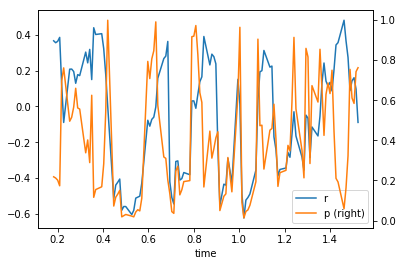

In [137]:
fig = validdf.plot(x='time',y='r')
validdf.plot(x='time',y='p',secondary_y=True,ax=fig)

and again, we do the same for the diff-of-single-values representation of audiff...

/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


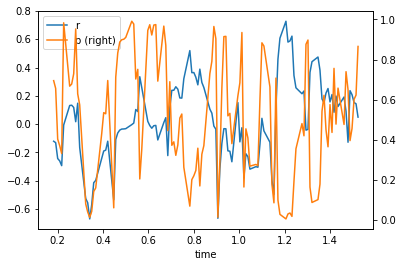

In [139]:
duration = .15
rs = []
ps = []

starttimes = [t for t in validdf['time'] if t+duration < np.max(validdf['time'])]

for starttime in starttimes:
    subdf = validdf[(validdf['time'] >= starttime) & (validdf['time'] <= starttime+duration)]
    sts = stats.linregress(x=subdf['cordiff'], y=subdf['au_diff2_val'])
    rs = rs + [sts.rvalue]
    ps = ps + [sts.pvalue]

validdf['r'] = pd.Series(rs)
validdf['p'] = pd.Series(ps)

fig = validdf.plot(x='time',y='r')
validdf.plot(x='time',y='p',secondary_y=True,ax=fig)

interesting. I'm not sure if it's less good or not. Open the praat!